# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.plsr import MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
ABC_mc = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)

header = ABC_mc.columns
treatments = ABC_mc.columns[2:]

data = ABC_mc.iloc[:,2:].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

In [20]:
ABC_mc

(84, 12)

### Phenotypes

#### Cell Viability:

% Confluency:

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]

Optionally take the fold-change to t=0:

In [5]:
# Y_cv.iloc[:, 1:] = Y_cv.iloc[:, 1:].div(Y_cv.iloc[0, 1:], axis = 1)

Define time-point of interest:

In [6]:
Y_cv = Y_cv[Y_cv["Elapsed"] == 87].iloc[0, 1:11]

## 1. Cross-validation

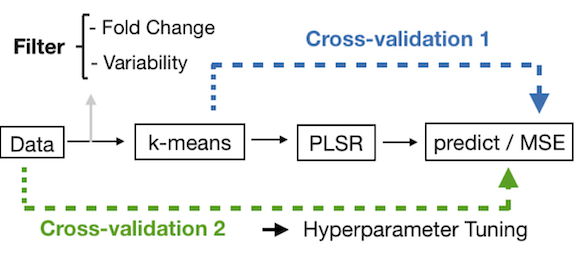

In [7]:
from IPython.display import Image
Image(filename='Model_pipeline.jpg')

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [8]:
ncl = 4

In [9]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

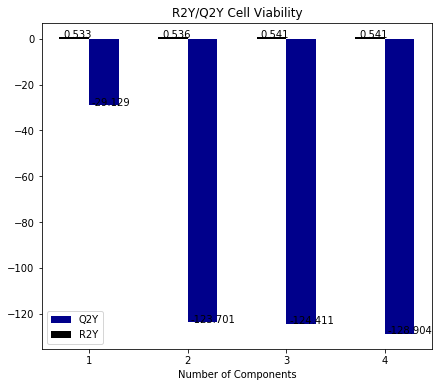

In [10]:
maxComp = ncl
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [11]:
CVresults_max, CVresults_min, best_params = kmeansPLSR_tuning(data, Y_cv)
CVresults_min.nlargest(20, "mean_test_scores")

,#Clusters,#Components,mean_test_scores,mean_train_scores
27,8,1,-493.315601,-253.178652
44,10,1,-536.761126,-245.427650
35,9,1,-571.357619,-251.895417
0,2,1,-614.009376,-284.029400
54,11,1,-685.382065,-240.539118
20,7,1,-723.329280,-246.283762
5,4,1,-732.895665,-286.490425
21,7,2,-739.163115,-186.176318
1,2,2,-750.435634,-276.340023
2,3,1,-756.719050,-288.814252


## 2. Model Predicted vs Actual for best Hyperparameter Set

In [12]:
ncl, ncomp = 4, 4

### 2.1 With CV Strategy 1:

Pearson's R:  0.03894609793402998 
 p-value:  0.9149345162375259


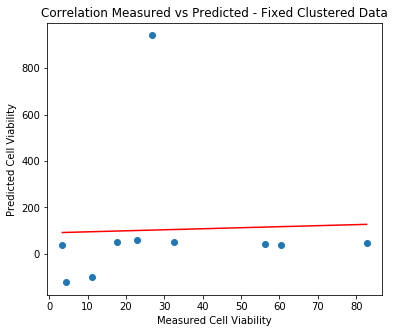

In [13]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(centers, Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

### 2.2 With CV Strategy 2:

In [14]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

In [15]:
X_scores, Y_scores = kmeans_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = kmeans_plsr.named_steps.plsr.x_loadings_[:, 0], kmeans_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = kmeans_plsr.named_steps.plsr.y_loadings_[:, 0], kmeans_plsr.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.4720784364267037 
 p-value:  0.1683274351645736


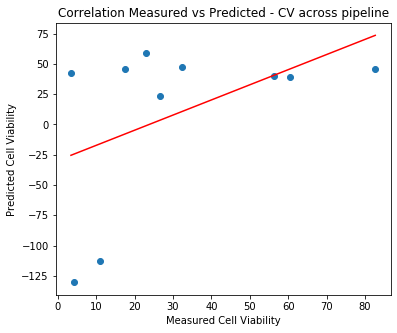

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data, Y_cv, kmeans_plsr, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

## 3. PLSR scores and loadings 

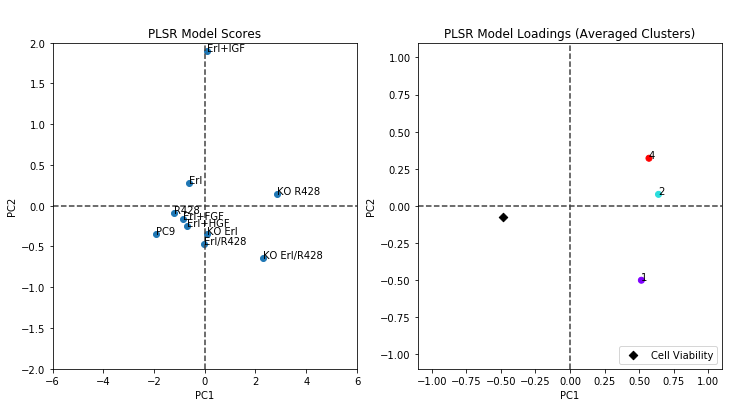

In [17]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-6, 6])
axs[0].set_ylim([-2, 2])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-1.1, 1.1])
axs[1].set_ylim([-1.1, 1.1]);

In [18]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,Cyclin-dependent kinase 1,PIRVYtHEVVT,"10 kDa heat shock protein, mitochondrial",PEYGGtKVVLD,Insulin receptor,YETDYyRKGGK,Twinfilin-2,TAEFLyDEVHP
1,Double-strand break repair protein MRE11,IEVDEsDVEED,182 kDa tankyrase-1-binding protein,GPPARsPsQDF,NaN,NaN,NaN,NaN
2,Filamin-A,EEVPRsPFKVK,60S acidic ribosomal protein P2,---MRyVASYL,NaN,NaN,NaN,NaN
3,Heterogeneous nuclear ribonucleoprotein U,YSRAKsPQPPV,60S ribosomal protein L22-like 1,TYELRyFQISQ,NaN,NaN,NaN,NaN
4,Heterogeneous nuclear ribonucleoprotein U-like...,DRRGRsPQPPA,ADP/ATP translocase 2,ANVIRyFPTQA,NaN,NaN,NaN,NaN
5,La-related protein 1,TFTAWsDEESD,ARF GTPase-activating protein GIT1,GADSDyENTQS,NaN,NaN,NaN,NaN
6,Zinc finger Ran-binding domain-containing prot...,IEREEsDGEYD,Abl interactor 1,TVPNDyMTSPA,NaN,NaN,NaN,NaN
7,NaN,NaN,Breast cancer anti-estrogen resistance protein 1,PAPDLyDVPPG,NaN,NaN,NaN,NaN
8,NaN,NaN,Choline-phosphate cytidylyltransferase A,AAYDIsEDEED,NaN,NaN,NaN,NaN
9,NaN,NaN,Cyclin-dependent kinase 16,LGEGTyATVYK,NaN,NaN,NaN,NaN


#### Cluster Averages across Conditions

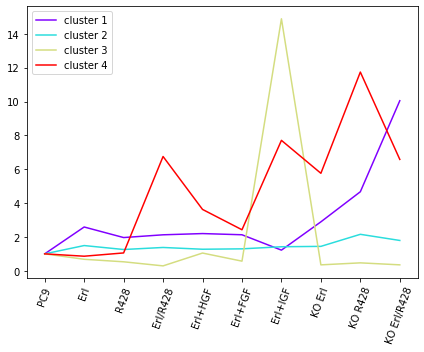

In [19]:
fig = plt.figure(figsize=(7,5))

centers = kmeans_plsr.named_steps.kmeans.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);